<a href="https://colab.research.google.com/github/NastiaSmoliakov/Final-Project/blob/main/pointNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install trimesh

import os
import glob
import trimesh
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

path = ""

def parse_dataset(path):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}

    train_files = glob.glob(os.path.join(path, "Training_1/**/*.csv"))
    train_files = np.array(train_files)
    train_size = len(train_files)
    perm = np.random.permutation(train_size)
    train_files = train_files[perm]

    test_files = glob.glob(os.path.join(path, "Test/*.csv"))
    test_files = np.array(test_files)
    test_size = len(test_files)
    perm = np.random.permutation(test_size)
    test_files = test_files[perm]

    for file in train_files:
        filename = file.split("/")[-1]
        if(filename.split("_")[0] == 'Right'):
            label = 1   #'Right'
        else:
            label = 0   #'Left'

        data = pd.read_csv(file).to_numpy()
        train_points.append(data)
        train_labels.append(label)

    for file in test_files:
        filename = file.split("/")[-1]
        if(filename.split("_")[0] == 'Right'):
            label = 1   #'Right'
        else:
            label = 0   #'Left'

        data = pd.read_csv(file).to_numpy()
        test_points.append(data)
        test_labels.append(label)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

NUM_POINTS = 150
NUM_CLASSES = 5
BATCH_SIZE = 16

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(path)

def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 16)
    x = conv_bn(x, 32)
    x = conv_bn(x, 256)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 128)
    x = dense_bn(x, 64)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,)(x)

    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

inputs = keras.Input(shape=(NUM_POINTS, 5))

x = tnet(inputs, 5)
x = conv_bn(x, 16)
x = conv_bn(x, 16)
x = tnet(x, 16)
x = conv_bn(x, 16)
x = conv_bn(x, 32)
x = conv_bn(x, 256)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 64)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=10, validation_data=test_dataset)

data = test_dataset.take(1)

test_data, test_labels = list(data)[0]
test_data = test_data[:10, ...]
test_labels = test_labels[:10, ...]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/gdrive
Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 5)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 150, 16)      96          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 150, 16)     64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                

1/1 [==============================] - 0s 293ms/step


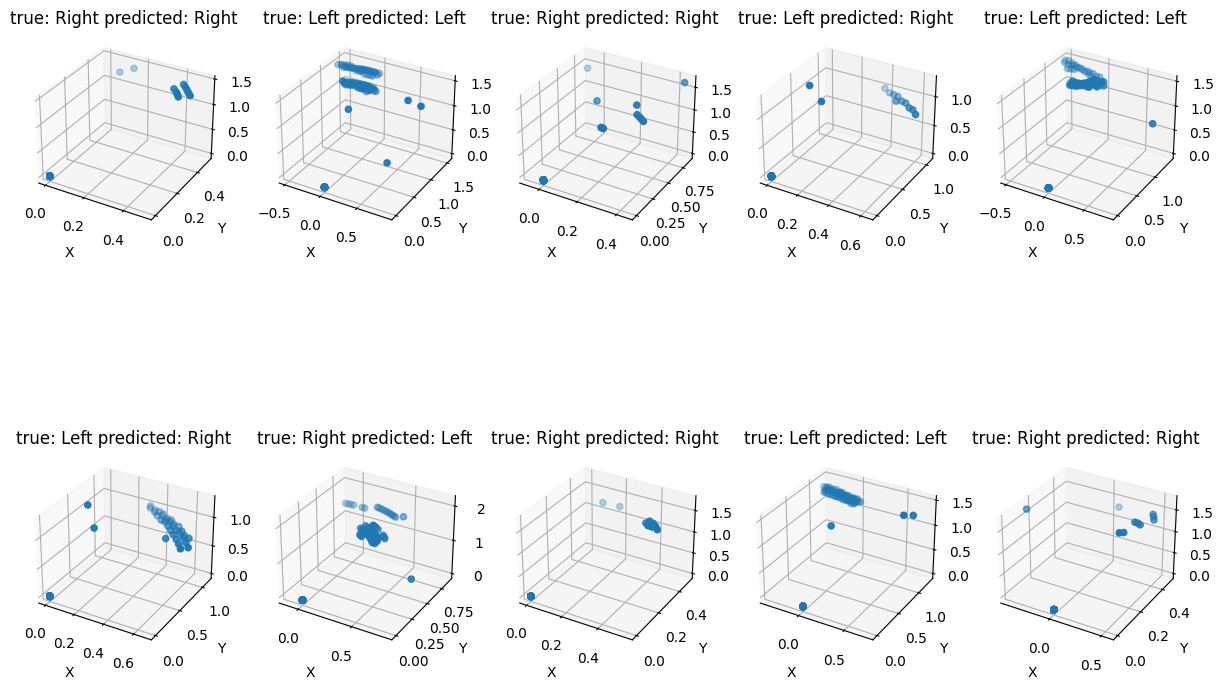

In [ ]:


preds = model.predict(test_data)
preds = tf.math.argmax(preds, -1)

points = test_data.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_xlabel('X', labelpad = 5)
    ax.set_ylabel('Y', labelpad = 5)
    ax.set_zlabel('Z', labelpad = 5)
    if test_labels[i].numpy() == 1:
        true_label = "Right"
    else:
        true_label = "Left"
    if preds[i].numpy() == 1:
        preds_label = "Right"
    else:
        preds_label = "Left"

    ax.set_title("true: "+true_label + " predicted: "+preds_label)
    #ax.set_axis_off()

plt.show()
